In [1]:
# Native imports
import sys
import os
import os.path
import json
from pprint import pprint
import urllib.request
import urllib.parse

# 3rd-party scraping/parsing imports
import requests
from bs4 import BeautifulSoup
import dateutil.parser as dt

# 3rd-party data science imports
import pandas as pd
import seaborn as sns

# Used to make the plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
FORCE_ORG_CATALOG_DOWNLOAD = True

In [3]:
ORGS_CATALOG_URL = 'https://callink.berkeley.edu/api/discovery/search/organizations?orderBy%5B0%5D=UpperName%20asc&top=1500'
ORG_CATEGORIES_URL = 'https://callink.berkeley.edu/api/discovery/organization/category?take=1000&orderByField=name'

ORG_JSON_FILE = 'data/callink-organizations.json'

ORG_URL = 'https://callink.berkeley.edu/organization/'
PROFILE_PIC_URL = 'https://se-infra-imageserver2.azureedge.net/clink/images/'

# Step 0: Download organization data


In [4]:
if FORCE_ORG_CATALOG_DOWNLOAD or not os.path.isfile(ORG_JSON_FILE):
    urllib.request.urlretrieve(ORGS_CATALOG_URL, ORG_JSON_FILE)

# Step 1: Load JSON files

In [5]:
# Load organizations file
with open(ORG_JSON_FILE) as fp:
    data = json.load(fp)
    
    num_orgs = data['@odata.count']
    print('Number of Organizations:', num_orgs)
    orgs = data['value']

Number of Organizations: 1308


# Step 2: Do some data cleaning and sanity checking

In [6]:
# Prep orgs dataframe
orgs_df = pd.DataFrame(orgs)
orgs_df = orgs_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
orgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   @search.score         1308 non-null   Int64 
 1   Id                    1308 non-null   Int64 
 2   InstitutionId         1308 non-null   Int64 
 3   ParentOrganizationId  1308 non-null   Int64 
 4   BranchId              1308 non-null   Int64 
 5   Name                  1308 non-null   string
 6   ShortName             1044 non-null   string
 7   WebsiteKey            1308 non-null   string
 8   ProfilePicture        1104 non-null   string
 9   Description           1075 non-null   string
 10  Summary               1308 non-null   string
 11  CategoryIds           1308 non-null   object
 12  CategoryNames         1308 non-null   object
 13  Status                1308 non-null   string
 14  Visibility            1308 non-null   string
dtypes: Int64(5), object(2), string(8)
memo

In [7]:
orgs_df.head()

,@search.score,Id,InstitutionId,ParentOrganizationId,BranchId,Name,ShortName,WebsiteKey,ProfilePicture,Description,Summary,CategoryIds,CategoryNames,Status,Visibility
0,1,136978,1660,45852,45852,180 Degrees Consulting at Berkeley,180DC,180dcberkeley,75258de9-3e52-4eac-902f-5e6c58534815ce019de6-d...,<p>180 Degrees Consulting is the world's large...,180 Degrees Consulting provides pro-bono consu...,"[2693, 5115, 5118, 7395, 7850, 9413, 9415, 10377]","[y ASUC Student Activity Groups, Professional ...",Active,Public
1,1,222008,1660,45852,45852,3D Modeling and Animation at Berkeley,3DMA@B,3d-modeling-and-animation-at-berkeley,636dc60c-77df-4fc6-ae01-0530ffd7b9e5ec000150-5...,"<div class=""x_x_x_x_x_x_x_x_x_page"" title=""Pag...",We are a student organization dedicated to edu...,"[5120, 7850]","[Technology Student Organizations, Undergradua...",Active,Public
2,1,326213,1660,45852,45852,5&2 Community Service,<NA>,5and2,a0992b37-4b8c-4336-9900-dca867a1bf83e0ac0b53-1...,<p>The purpose of this organization is to enga...,Our mission is to provide virtual volunteering...,[5118],[Service Student Organizations],Active,Public
3,1,91982,1660,45852,45852,A Better Way at Berkeley,ABW,abetterwayberkeley,e78e6767-c883-4bbd-9a39-7349e633a5ff1fd21fb7-8...,"<p><span style=""font-weight: 400;"">3% of foste...",**Active Fall 2020!!** We tutor foster kids ar...,"[5118, 7850]","[Service Student Organizations, Undergraduate ...",Active,Public
4,1,91428,1660,45852,45852,ABA,<NA>,aba,fd80d6dc-0890-4c90-927a-0d671b24f6df9719695c-f...,<p>ABA was founded in 1975 by a group of stude...,Berkeley ABA is a hybrid consulting organizati...,"[2693, 5115, 7850, 10377, 14365]","[y ASUC Student Activity Groups, Professional ...",Active,Public


In [8]:
# List unique values and their counts
# NOTE: We are excluding the 'Category' keys because lists aren't hashable
print('Unique value counts')
print('===================')
print(pd.Series({c: len(orgs_df[c].unique()) for c in orgs_df if 'Category' not in c}))

Unique value counts
@search.score              1
Id                      1308
InstitutionId              1
ParentOrganizationId       2
BranchId                   2
Name                    1308
ShortName               1025
WebsiteKey              1308
ProfilePicture          1105
Description             1076
Summary                 1285
Status                     1
Visibility                 1
dtype: int64


In [9]:
# Keep only columns that have more than 1 unique value
wanted_org_cols = ['Id', 'Name', 'ShortName', 'WebsiteKey', 'ProfilePicture',
                   'Description', 'Summary', 'CategoryIds', 'CategoryNames']
orgs_df = orgs_df[wanted_org_cols]
orgs_df

,Id,Name,ShortName,WebsiteKey,ProfilePicture,Description,Summary,CategoryIds,CategoryNames
0,136978,180 Degrees Consulting at Berkeley,180DC,180dcberkeley,75258de9-3e52-4eac-902f-5e6c58534815ce019de6-d...,<p>180 Degrees Consulting is the world's large...,180 Degrees Consulting provides pro-bono consu...,"[2693, 5115, 5118, 7395, 7850, 9413, 9415, 10377]","[y ASUC Student Activity Groups, Professional ..."
1,222008,3D Modeling and Animation at Berkeley,3DMA@B,3d-modeling-and-animation-at-berkeley,636dc60c-77df-4fc6-ae01-0530ffd7b9e5ec000150-5...,"<div class=""x_x_x_x_x_x_x_x_x_page"" title=""Pag...",We are a student organization dedicated to edu...,"[5120, 7850]","[Technology Student Organizations, Undergradua..."
2,326213,5&2 Community Service,<NA>,5and2,a0992b37-4b8c-4336-9900-dca867a1bf83e0ac0b53-1...,<p>The purpose of this organization is to enga...,Our mission is to provide virtual volunteering...,[5118],[Service Student Organizations]
3,91982,A Better Way at Berkeley,ABW,abetterwayberkeley,e78e6767-c883-4bbd-9a39-7349e633a5ff1fd21fb7-8...,"<p><span style=""font-weight: 400;"">3% of foste...",**Active Fall 2020!!** We tutor foster kids ar...,"[5118, 7850]","[Service Student Organizations, Undergraduate ..."
4,91428,ABA,<NA>,aba,fd80d6dc-0890-4c90-927a-0d671b24f6df9719695c-f...,<p>ABA was founded in 1975 by a group of stude...,Berkeley ABA is a hybrid consulting organizati...,"[2693, 5115, 7850, 10377, 14365]","[y ASUC Student Activity Groups, Professional ..."
...,...,...,...,...,...,...,...,...,...
1303,235068,Young Musicians Outreach at Berkeley,<NA>,youngmusiciansoutreach,02663c5c-165a-4715-9926-1cea79654be93b318221-1...,<p>A volunteer organization teaching piano and...,A volunteer organization teaching piano and co...,"[5100, 7850]","[Arts Student Organizations, Undergraduate Org..."
1304,91258,Youth Advocacy Project,YAP,youthadvocacyproject,<NA>,<p>Students will work as youth advocates to su...,Enable law students to get experience with dir...,"[2691, 5118]","[GSG - Graduate Student Groups, Service Studen..."
1305,46461,Zawadi: Black LGBTQ Community at Berkeley,<NA>,zawadi,e543d5e4-0767-4729-ba73-7a25006c809e77ab99c4-b...,<p>We are interested in increasing visibility ...,"This group is a social, academic, and politica...","[2691, 7853]","[GSG - Graduate Student Groups, Cultural & Ide..."
1306,181872,Zeta Chi Consulting,ZC Consulting,zcconsulting,dabebe05-2feb-444d-8b23-791bd72bef9351c89da1-6...,<NA>,ZC Consulting seeks to bring together students...,"[5115, 7850]","[Professional Student Organizations, Undergrad..."


# Step 3: Scrape the data

In [10]:
'''
Strategy: Although we have to navigate into each link to get the email and any other important info,
the good part is we don't need to fully render the page despite CalLink being done in React.

'window.initialAppState' is the key, so we just need to fetch that for each organization and we're
good to go!
'''

PHOTOS_DOWNLOAD = False

# Make the needed folders for downloading "debug" files
COVER_PHOTOS_DIR = 'data/cover_pics/'
PROFILE_PHOTOS_DIR = 'data/profile_pics/'
APP_STATE_DIR = 'data/app_states/'

os.makedirs(COVER_PHOTOS_DIR, exist_ok=True)
os.makedirs(PROFILE_PHOTOS_DIR, exist_ok=True)
os.makedirs(APP_STATE_DIR, exist_ok=True)

def fetch_html_page(url):
    return requests.get(url).text.strip()

def fetch_init_app_state(soup):
    for element in soup.find_all('script'):
        if len(element.contents) > 0 and 'window.initialAppState' in element.contents[0]:
            json_str = element.contents[0].split(' = ')[1][:-1]
            return json.loads(json_str)
    return None

def safe_fetch(obj, key):
    return (None if pd.isna(obj.get(key)) else obj[key].strip()) or None

def process_org(org_row):
    
    # Non-nullable initial fields
    org_id         = safe_fetch(org_row, 'WebsiteKey')
    org_name       = safe_fetch(org_row, 'Name')
    org_summary    = safe_fetch(org_row, 'Summary')
    org_categories = [name.strip() for name in org_row.get('CategoryNames')]
    
    # Nullable initial fields
    org_short_name  = safe_fetch(org_row, 'ShortName')
    org_description = safe_fetch(org_row, 'Description')
    
    
    if not os.path.isfile(APP_STATE_DIR + f'{org_id}.json'):
        # Fetch the app state in the org page
        html = fetch_html_page(ORG_URL + org_id)
        soup = BeautifulSoup(html, 'html.parser')
        app_state = fetch_init_app_state(soup)

        # Save the app state for debugging purposes
        with open(APP_STATE_DIR + f'{org_id}.json', 'w') as fp:
            json.dump(app_state, fp)
    else:
        # Load the app state from the JSON file
        with open(APP_STATE_DIR + f'{org_id}.json', 'r') as fp:
            app_state = json.load(fp)
            
    # Shortcut to important organization info
    org_details = app_state['preFetchedData']['organization']
    
    if PHOTOS_DOWNLOAD and not os.path.isfile(COVER_PHOTOS_DIR + f'{org_id}-cover.jpg'):
        # Save the cover photo
        cover_photo_url = app_state['coverPhoto']['url'].strip()
        urllib.request.urlretrieve(cover_photo_url, COVER_PHOTOS_DIR + f'{org_id}-cover.jpg')
    
    if PHOTOS_DOWNLOAD and not os.path.isfile(PROFILE_PHOTOS_DIR + f'{org_id}-profile.jpg'):
        # Save the profile photo
        if org_details['profilePicture'] is not None:
            profile_photo_url = PROFILE_PIC_URL + org_details['profilePicture'].strip()
            urllib.request.urlretrieve(profile_photo_url, PROFILE_PHOTOS_DIR + f'{org_id}-profile.jpg')
    
    # Get the email, phone, and social media links
    email = safe_fetch(org_details, 'email')
    
    if (len(org_details['contactInfo']) > 1):
        print('ALERT - multi contact info', org_id)
    
    if (len(org_details['contactInfo']) == 1):
        contact_info_obj = org_details['contactInfo'][0]
        phone     = safe_fetch(contact_info_obj, 'phoneNumber')
        phone_ext = safe_fetch(contact_info_obj, 'extension')
    else:
        phone = None
        phone_ext = None
    
    if org_details['primaryContact'] is not None:
        primary_contact_name = f"{org_details['primaryContact']['firstName']} {org_details['primaryContact']['lastName']}".strip()
        primary_contact_email = org_details['primaryContact']['primaryEmailAddress'].strip()
    else:
        primary_contact_name = None
        primary_contact_email = None
    
    social_media_tag_map = [
        ('website', 'externalWebsite'),
        ('flickr', 'flickrUrl'),
        ('google-calendar', 'googleCalendarUrl'),
        ('google-plus', 'googlePlusUrl'),
        ('instagram', 'instagramUrl'),
        ('linkedin', 'linkedInUrl'),
        ('pinterest', 'pinterestUrl'),
        ('tumblr', 'tumblrUrl'),
        ('vimeo', 'vimeoUrl'),
        ('youtube', 'youtubeUrl'),
        ('facebook', 'facebookUrl'),
        ('twitter-url', 'twitterUrl'),
        ('twitter-user', 'twitterUserName')
    ]
    
    social_media = {}
    for (native_tag, alien_tag) in social_media_tag_map:
        smedia_obj = org_details['socialMedia']
        social_media[native_tag] = safe_fetch(smedia_obj, alien_tag)
        
    org_start_date = dt.parse(org_details['startDate'])
    if org_start_date.timestamp() < 0:
        org_start_date = None
    else:
        org_start_date = org_start_date.date()
    
    return {
        'id': org_id, 
        'name': org_name,
        'has-profile-pic': org_details['profilePicture'] is not None,
        'has-cover-pic': True,
        # NOTE: There hasn't been a case where an org has no cover photo as of yet.
        'start-date': org_start_date,
        'summary': org_summary,
        'categories': org_categories,
        'short-name': org_short_name,
        'description': org_description,
        'email': email,
        'phone': phone,
        'phone-ext': phone_ext,
        'social-media': social_media
    }

processed_org_data = []

for (index, row) in orgs_df.iterrows():
    try:
        processed_org = process_org(row)
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print(f"Problematic organization: {row['WebsiteKey']}")
        raise
    processed_org_data += [processed_org]
    
    if ((index + 1) % 50 == 0):
        print(f'{(index + 1)} / {num_orgs} organizations processed')
print('All orgs processed!')

50 / 1308 organizations processed
100 / 1308 organizations processed
150 / 1308 organizations processed
200 / 1308 organizations processed
250 / 1308 organizations processed
300 / 1308 organizations processed
350 / 1308 organizations processed
400 / 1308 organizations processed
450 / 1308 organizations processed
500 / 1308 organizations processed
550 / 1308 organizations processed
600 / 1308 organizations processed
650 / 1308 organizations processed
700 / 1308 organizations processed
750 / 1308 organizations processed
800 / 1308 organizations processed
850 / 1308 organizations processed
900 / 1308 organizations processed
950 / 1308 organizations processed
1000 / 1308 organizations processed
1050 / 1308 organizations processed
1100 / 1308 organizations processed
1150 / 1308 organizations processed
1200 / 1308 organizations processed
1250 / 1308 organizations processed
1300 / 1308 organizations processed
All orgs processed!


In [11]:
# Let's make a DataFrame from all this new data
new_orgs_df = pd.DataFrame(processed_org_data).convert_dtypes()
new_orgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1308 non-null   string 
 1   name             1308 non-null   string 
 2   has-profile-pic  1308 non-null   boolean
 3   has-cover-pic    1308 non-null   boolean
 4   start-date       851 non-null    object 
 5   summary          1308 non-null   string 
 6   categories       1308 non-null   object 
 7   short-name       1043 non-null   string 
 8   description      1075 non-null   string 
 9   email            1023 non-null   string 
 10  phone            220 non-null    string 
 11  phone-ext        2 non-null      string 
 12  social-media     1308 non-null   object 
dtypes: boolean(2), object(3), string(8)
memory usage: 117.6+ KB


In [12]:
# Let's also make a "sub" DataFrame for the social media links
social_media_map = pd.DataFrame(processed_org_data)['social-media'].values.tolist()
orgs_social_df = pd.DataFrame(social_media_map).convert_dtypes()
orgs_social_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   website          778 non-null    string
 1   flickr           13 non-null     string
 2   google-calendar  68 non-null     string
 3   google-plus      1 non-null      string
 4   instagram        463 non-null    string
 5   linkedin         152 non-null    string
 6   pinterest        1 non-null      string
 7   tumblr           6 non-null      string
 8   vimeo            4 non-null      string
 9   youtube          120 non-null    string
 10  facebook         817 non-null    string
 11  twitter-url      64 non-null     string
 12  twitter-user     211 non-null    string
dtypes: string(13)
memory usage: 133.0 KB


# Step 4: Visualize and understand the data

<AxesSubplot:>

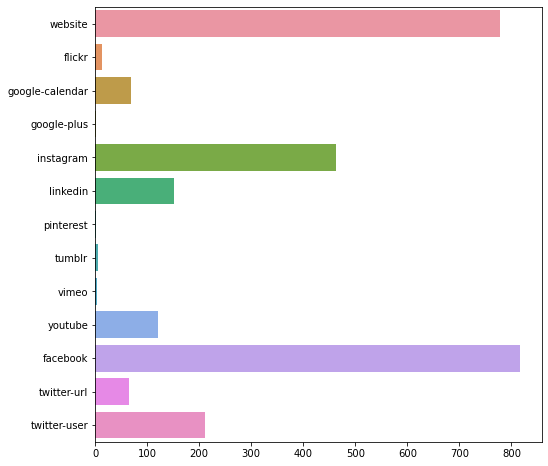

In [13]:
# Visual plot to show 
sns.barplot(y=orgs_social_df.count().index, x=orgs_social_df.count())

In [14]:
orgs_social_df.count()

website            778
flickr              13
google-calendar     68
google-plus          1
instagram          463
linkedin           152
pinterest            1
tumblr               6
vimeo                4
youtube            120
facebook           817
twitter-url         64
twitter-user       211
dtype: int64

<AxesSubplot:xlabel='start-date', ylabel='email'>

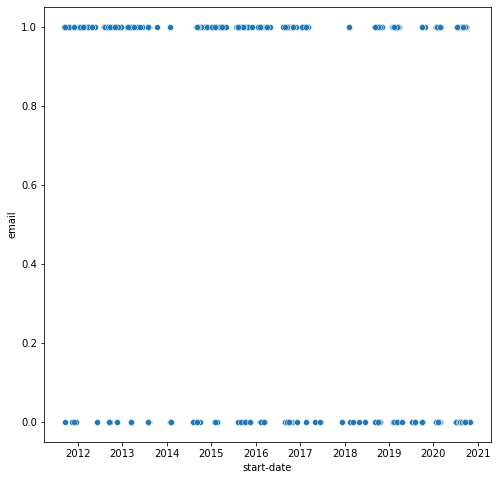

In [15]:
# Trying to see if the age of the club has any correlation to the club having an email or not
# Results: No correlation
sns.scatterplot(
    x=new_orgs_df['start-date'],
    y=new_orgs_df['email'].apply(lambda email: not pd.isna(email))
)

In [16]:
valid_start_date_indices = new_orgs_df['start-date'].notnull()
valid_start_dates = new_orgs_df['start-date'][valid_start_date_indices]

print('Oldest club start:', min(valid_start_dates))
print('Newest club start:', max(valid_start_dates))

Oldest club start: 2011-09-13
Newest club start: 2020-10-30


<AxesSubplot:xlabel='start-date', ylabel='email'>

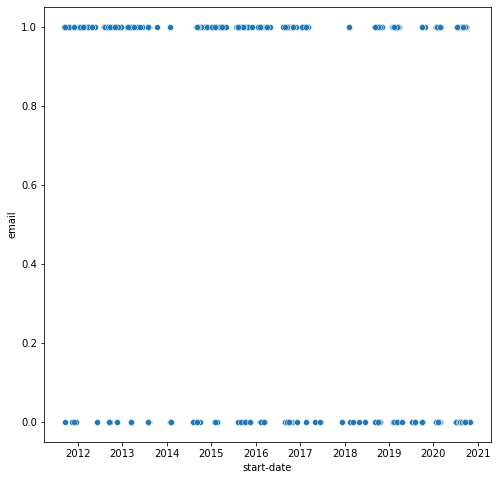

In [17]:
# Trying to see if the age of the club has any correlation to the club having an email or not
# Results: No correlation
sns.scatterplot(
    x=new_orgs_df['start-date'][valid_start_date_indices],
    y=new_orgs_df['email'].apply(lambda email: not pd.isna(email))
)

In [18]:
# Save all this data into a massive JSON file

from datetime import datetime, date

OUTPUT_ORG_INFO_FILE = 'exported/org-info.json'

# Allows handling of datetimes
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        return obj.isoformat()
    raise TypeError ("Type %s not serializable" % type(obj))


with open(OUTPUT_ORG_INFO_FILE, 'w') as fp:
    json.dump(processed_org_data, fp, default=json_serial)

In [19]:
OUTPUT_ORG_EMAILS = 'exported/org-emails.json'

all_club_emails = [org['email'].lower() for org in processed_org_data if org['email'] is not None]
with open(OUTPUT_ORG_EMAILS, 'w') as fp:
    json.dump(all_club_emails, fp, default=json_serial)

# Step 5: Further analysis

In [20]:
print('Max length of club name:', new_orgs_df['name'].apply(len).max())
print('Max length of summary:', new_orgs_df['summary'].dropna().apply(len).max())
print('Max length of description:', new_orgs_df['description'].dropna().apply(len).max())

Max length of club name: 134
Max length of summary: 255
Max length of description: 11816


In [21]:
summary_lengths = new_orgs_df['summary'].dropna().apply(lambda summary: len(summary)).to_list()
print('Number of summaries:', len(summary_lengths))

descr_lengths = new_orgs_df['description'].dropna().apply(lambda summary: len(summary)).to_list()
print('Number of descriptions:', len(descr_lengths))

Number of summaries: 1308
Number of descriptions: 1075


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

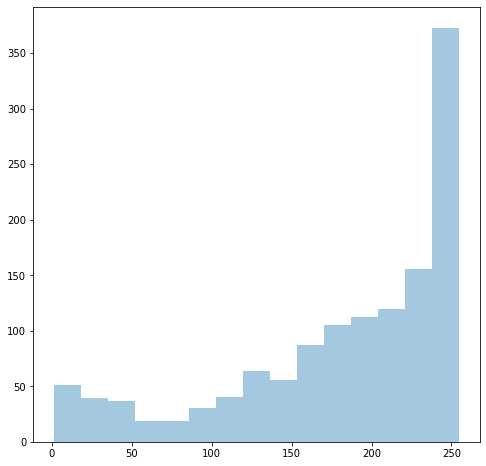

In [22]:
sns.distplot(summary_lengths, kde=False)

0.8437209302325581


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

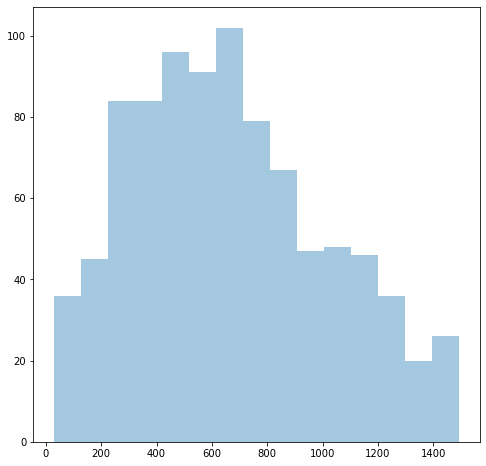

In [22]:
new_descr_lengths = [length for length in descr_lengths if length <= 1500]
print(len(new_descr_lengths) / len(descr_lengths))
sns.distplot(new_descr_lengths, kde=False)